# GBDT para detecção de anomalias

O GBDT é mais indicado para dados tabulares estruturados, oferecendo alta precisão e interpretabilidade, mas exige labels e pode ser mais custoso. O Isolation Forest é simples, rápido e não supervisionado, funcionando bem em grandes volumes de dados, embora seja limitado em capturar relações complexas. Já os Autoencoders se destacam em dados de alta dimensão e não estruturados, como imagens ou séries temporais, conseguindo modelar padrões complexos, mas com menor interpretabilidade e maior custo computacional.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pre processing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# classifiers
from catboost import CatBoostClassifier, Pool
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# valuation
from sklearn.metrics import classification_report,f1_score, accuracy_score, roc_curve, auc, roc_auc_score

from datetime import datetime

# seed para reprodução dos resultados
RANDOM = 42

# define a gpu a ser usada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df_train = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")
df_test = pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv")

In [3]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df_train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

## Pré-processamento

In [6]:
# remove colunas que não serão utilizadas
columns_to_drop = ['Unnamed: 0', 'trans_num', 'first', 'last', 'gender', 'city_pop', \
                    'zip', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'job', 'lat', 'long']

df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

In [7]:
df_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,0


In [8]:
# procura linhas com valores nulos ou infinitos
def filter_null_inf(df): 
    df.isna().sum()
    df[df.isin([float("inf"), float("-inf")]).any(axis=1)]
    
    # remove valores infinitos e não numericos
    df = df.replace([float("inf"), float("-inf")], pd.NA)
    df = df.dropna()

    return df

df_train = filter_null_inf(df_train)
df_test = filter_null_inf(df_test)

In [9]:
# convertendo data e horário em atributos numéricos
def convert_date(df):
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], format='%Y-%m-%d %H:%M:%S')
    df["year"] = df["trans_date_trans_time"].dt.year
    df["month"] = df["trans_date_trans_time"].dt.month
    df["day"] = df["trans_date_trans_time"].dt.day
    df["hour"] = df["trans_date_trans_time"].dt.hour
    df["minute"] = df["trans_date_trans_time"].dt.minute
    df["second"] = df["trans_date_trans_time"].dt.second
    
    # remove a feature original
    df = df.drop(columns=["trans_date_trans_time"])
    return df

df_train = convert_date(df_train)
df_test = convert_date(df_test)

In [10]:
# checa resultado após pré-processamento
df_train.head()

,cc_num,merchant,category,amt,street,city,state,is_fraud,year,month,day,hour,minute,second
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,0,2019,1,1,0,0,18
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,0,2019,1,1,0,0,44
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,0,2019,1,1,0,0,51
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,0,2019,1,1,0,1,16
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,0,2019,1,1,0,3,6


In [11]:
df_train["is_fraud"].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [12]:
# define features categoricas e numericas
CATEGORICAL_FEATURES = ['merchant', 'category', 'street', 'city', 'state']
NUMERIC_FEATURES = ['cc_num', 'amt', 'year', 'month', 'day', 'hour', 'minute', 'second']
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES
TARGET_FEATURE = 'is_fraud'

## EDA

[]

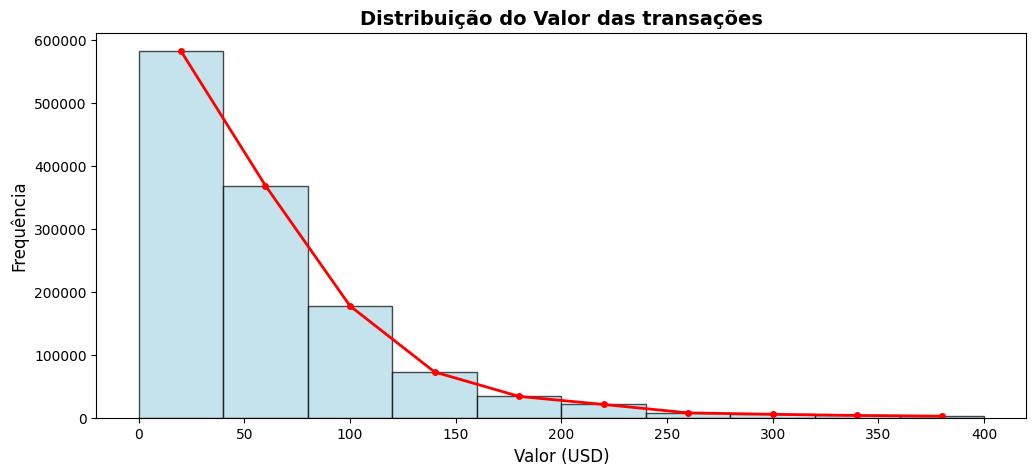

In [13]:
plt.figure(figsize=(12, 5))

# histograma com linha de frequência
counts, bins, patches = plt.hist(df_train['amt'],color='lightblue', edgecolor='black', range=(0, 400), alpha=0.7)

# adicionar linha conectando os pontos médios dos bins
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, counts, color='red', linewidth=2, marker='o', markersize=4)
plt.title('Distribuição do Valor das transações', fontsize=14, fontweight='bold')
plt.xlabel('Valor (USD)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.plot()

### Data Split

In [14]:
X_train, y_train = df_train.drop(columns=["is_fraud"]), df_train["is_fraud"]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=RANDOM)
X_test, y_test = df_test.drop(columns=["is_fraud"]), df_test["is_fraud"] 

In [15]:
# # transforma a variavel target em numerica 
# def prepare_targets(y_train, y_test):
# 	le = LabelEncoder()
# 	le.fit(y_train)
# 	y_train_enc = le.transform(y_train)
# 	y_test_enc = le.transform(y_test)
# 	return y_train_enc, y_test_enc

# y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

## Gradient Boosted Decision Tree

Para fins de comparação, escolhi o `catboost` como classificador pois ele conta com diversas vantagens relevantes para o problema específico:

- Suporte nativo a variáveis categóricas.
- hiperparâmetros padrão competitivos contra modelos ajustados de XGBoost/LightGBM.
- Robustez contra overfitting, principalmente em datasets menores

ref.: https://catboost.ai/docs/en/

In [16]:
clf = CatBoostClassifier(
    iterations=120,
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
    eval_metric='Logloss',
    task_type="GPU",
    random_seed=RANDOM
)

clf.fit(X_train, y_train, 
        cat_features=CATEGORICAL_FEATURES, 
        eval_set=(X_val, y_val),
        use_best_model=True
)

print('CatBoost model parameters:')
print(clf.get_params())

0:	learn: 0.5997549	test: 0.5997477	best: 0.5997477 (0)	total: 6.91s	remaining: 13m 42s
1:	learn: 0.5231228	test: 0.5231100	best: 0.5231100 (1)	total: 6.92s	remaining: 6m 48s
2:	learn: 0.4593796	test: 0.4593645	best: 0.4593645 (2)	total: 6.93s	remaining: 4m 30s
3:	learn: 0.4053774	test: 0.4053555	best: 0.4053555 (3)	total: 6.95s	remaining: 3m 21s
4:	learn: 0.3592697	test: 0.3592428	best: 0.3592428 (4)	total: 6.96s	remaining: 2m 40s
5:	learn: 0.3197038	test: 0.3196737	best: 0.3196737 (5)	total: 6.97s	remaining: 2m 12s
6:	learn: 0.2852852	test: 0.2852482	best: 0.2852482 (6)	total: 6.98s	remaining: 1m 52s
7:	learn: 0.2552900	test: 0.2552460	best: 0.2552460 (7)	total: 6.99s	remaining: 1m 37s
8:	learn: 0.2291279	test: 0.2290873	best: 0.2290873 (8)	total: 7s	remaining: 1m 26s
9:	learn: 0.2061703	test: 0.2061278	best: 0.2061278 (9)	total: 7.02s	remaining: 1m 17s
10:	learn: 0.1851633	test: 0.1851019	best: 0.1851019 (10)	total: 7.03s	remaining: 1m 9s
11:	learn: 0.1667160	test: 0.1666455	best: 0

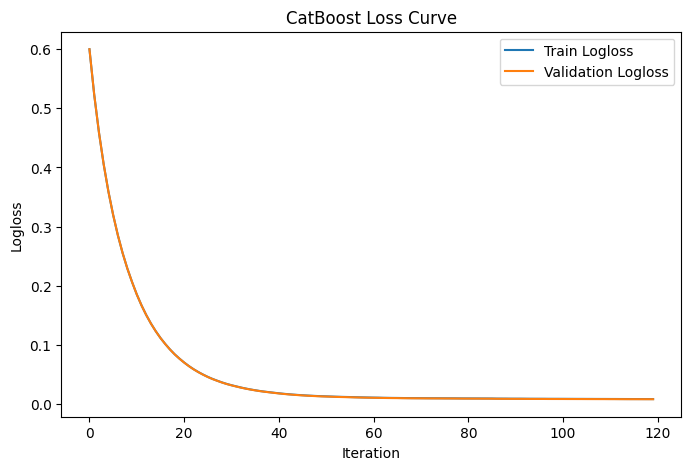

In [17]:
# pega a loss de training e validation por interacao
train_log = clf.get_evals_result()['learn']['Logloss']
val_log = clf.get_evals_result()['validation']['Logloss']

plt.figure(figsize=(8,5))
plt.plot(train_log, label='Train Logloss')
plt.plot(val_log, label='Validation Logloss')
plt.xlabel("Iteration")
plt.ylabel("Logloss")
plt.title("CatBoost Loss Curve")
plt.legend()
plt.show()

In [18]:
# testando
y_pred_gbdt = clf.predict(X_test)

print("Report:\n", classification_report(y_test, y_pred_gbdt))

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.86      0.63      0.73      2145

    accuracy                           1.00    555719
   macro avg       0.93      0.82      0.86    555719
weighted avg       1.00      1.00      1.00    555719



In [19]:
def plot_roc_curve(y_true, y_pred_proba, save_path=None):
    # calcula a curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

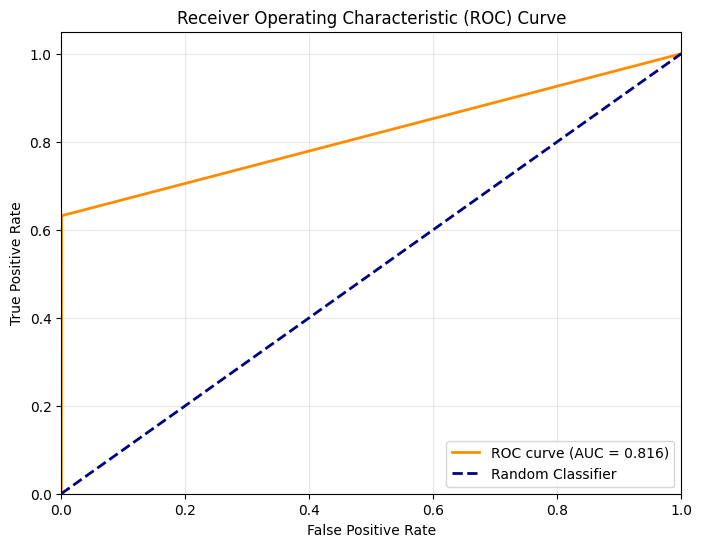

0.815650300653209

In [20]:
plot_roc_curve(y_test, y_pred_gbdt)

## FT-Transformer

In [21]:
# codifica variaveis categoricas
def preprocess_features(df, ord_encoders=None):
    df = df.copy()
    
    if ord_encoders:
        for col in CATEGORICAL_FEATURES:
            df[col] = ord_encoders[col].transform(df[[col]].astype(str))            
    else:
        ord_encoders = {}
        for col in CATEGORICAL_FEATURES:
            ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            df[col] = ord_enc.fit_transform(df[[col]].astype(str))
            ord_encoders[col] = ord_enc
    
    # converte colunas para o formato numerico
    df['cc_num'] = df['cc_num'].astype('float32')
    df['amt'] = df['amt'].astype('float32')
    
    # converte variaveis inteiras para int32 (compativeis com TensorFlow)
    int_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
    for col in int_columns:
        df[col] = df[col].astype('float32')
    for col in CATEGORICAL_FEATURES:
        df[col] = df[col].astype('float32')
    
    return df, ord_encoders

print("Preprocessing training data...")
X_train_processed, train_encoders = preprocess_features(X_train)
X_val_processed, _ = preprocess_features(X_val, train_encoders)
X_test_processed, _ = preprocess_features(X_test, train_encoders)

Preprocessing training data...


In [22]:
# padronizando as features
scaler = StandardScaler()
X_train_processed = pd.DataFrame(scaler.fit_transform(X_train_processed))
X_val_processed = pd.DataFrame(scaler.transform(X_val_processed))
X_test_processed = pd.DataFrame(scaler.transform(X_test_processed))

In [23]:
# define o transformer tabular
class TabTransformer(nn.Module):
    def __init__(self, num_features, num_classes, dim_embedding=64, num_heads=4, num_layers=4):
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(dim_embedding, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Adding a sequence length dimension
        x = self.transformer(x)
        x = torch.mean(x, dim=1)  # Pooling
        x = self.classifier(x)
        return x

In [24]:
# parametros do modelo
num_features = X_train_processed.shape[1]
num_classes = 2

In [25]:
# inicializa o modelo, loss e o optimizer
model = TabTransformer(num_features, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# convertendo os dados para tensores
# treino
X_train_tensor = torch.FloatTensor(X_train_processed.values).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# validacao
X_val_tensor = torch.FloatTensor(X_val_processed.values).to(device)
y_val_tensor = torch.LongTensor(y_val.values).to(device)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [26]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # train mode
    model.train(True)
    
    # pega os batches para treinamento 
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # zera o gradiente para cada batch
        optimizer.zero_grad()

        # previsao do modelo
        outputs = model(inputs)
        
        # computa o custo e seus gradientes
        loss = loss_fn(outputs, labels)
        loss.backward()

        # ajusta os pesos de treino
        optimizer.step()

        # reporte
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # custo por batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [27]:
def validate_one_epoch():
    # evaluation mode
    model.eval()

    # desabilita o calculo do gradiente para melhorar a eficiencia
    # do programa
    running_vloss = 0.0   # registra o custo ao longo de varios batches
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            
    avg_vloss = running_vloss / (i + 1)
    return avg_vloss.item()

In [28]:
# https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train_model(epochs):
    # Initializing in a separate cell so we can easily add more epochs to the same run
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # inicializa variaveis
    train_losses = []
    val_losses = []
    epoch_number = 0
    best_vloss = 1_000_000.
    
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))
    
        # treino
        avg_train_loss = train_one_epoch(epoch_number)    

        # validacao
        avg_val_loss = validate_one_epoch()

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print('LOSS train {} valid {}'.format(avg_train_loss, avg_val_loss))
        
        # grava a melhor perda e salva o modelo
        if avg_val_loss < best_vloss:
            best_vloss = avg_val_loss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)
    
        epoch_number += 1

    return train_losses, val_losses

In [29]:
# treina o modelo
EPOCHS = 80
train_losses, val_losses = train_model(EPOCHS)

EPOCH 1:
  batch 1000 loss: 0.02206877335871104
  batch 2000 loss: 0.02138837359647732
  batch 3000 loss: 0.01820370407914743
  batch 4000 loss: 0.019139754013507627
  batch 5000 loss: 0.017929105974850246
  batch 6000 loss: 0.018119381914613767
  batch 7000 loss: 0.01663373721810058
  batch 8000 loss: 0.01615503606875427
  batch 9000 loss: 0.017062763966911008
LOSS train 0.017062763966911008 valid 0.0152595741674304
EPOCH 2:
  batch 1000 loss: 0.016444061107176822
  batch 2000 loss: 0.01642249128385447
  batch 3000 loss: 0.016130476058577186
  batch 4000 loss: 0.015187084921228234
  batch 5000 loss: 0.016296367364062463
  batch 6000 loss: 0.015933369333622976
  batch 7000 loss: 0.01470976165792672
  batch 8000 loss: 0.0158039270680747
  batch 9000 loss: 0.014821362721151672
LOSS train 0.014821362721151672 valid 0.013707940466701984
EPOCH 3:
  batch 1000 loss: 0.01560489225195488
  batch 2000 loss: 0.015121226108807605
  batch 3000 loss: 0.013345893267716747
  batch 4000 loss: 0.014573

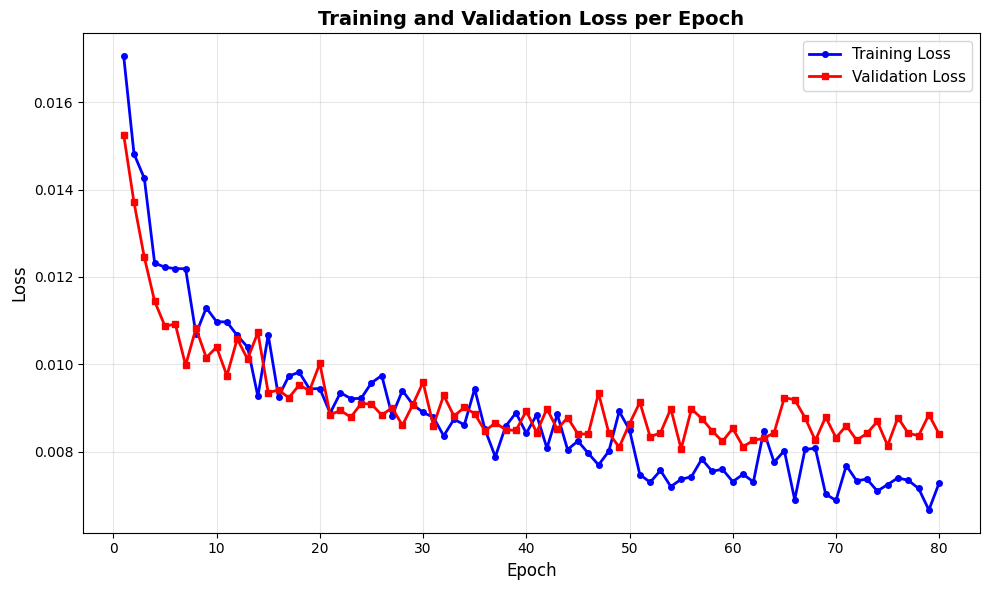


Best validation loss: 0.0081 at epoch 55


In [30]:
# plota os resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=4)
plt.plot(range(1, EPOCHS + 1), val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss per Epoch', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest validation loss: {min(val_losses):.4f} at epoch {val_losses.index(min(val_losses)) + 1}")

## Resultados

In [31]:
# dataset de teste
X_test_tensor = torch.FloatTensor(X_test_processed.values).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

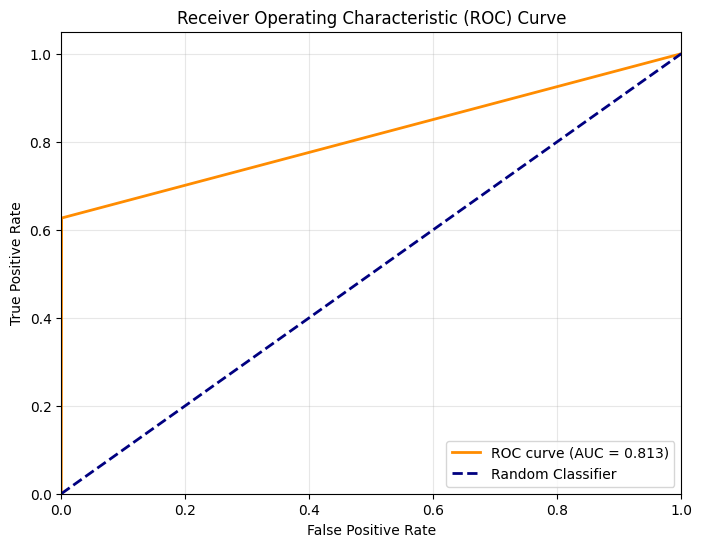

MODEL PERFORMANCE METRICS
Accuracy:           0.9980 (99.80%)
F1 Score (Negative): 0.9990
F1 Score (Positive): 0.7100



In [32]:
def calculate_metrics(model, dataloader, device=device, roc=True):
    """
    Calcula acurácia e scores F1 para classes positivas e negativas
    """
    model.eval()
    all_preds = []
    all_labels = []

    # predicao
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # calcula metricas
    accuracy = accuracy_score(all_labels, all_preds)
    f1_scores = f1_score(all_labels, all_preds, average=None)
    
    metrics = {
        'accuracy': accuracy,
        'f1_negative': f1_scores[0],
        'f1_positive': f1_scores[1] if len(f1_scores) > 1 else f1_scores[0]
    }

    # plota a curva roc
    if roc:
        plot_roc_curve(all_labels, all_preds)
    
    return metrics


metrics = calculate_metrics(model, test_loader, device)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy:           {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"F1 Score (Negative): {metrics['f1_negative']:.4f}")
print(f"F1 Score (Positive): {metrics['f1_positive']:.4f}")
print("="*50 + "\n")